In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt

from prophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load & Inspect Data

In [91]:
# Concert to csv
df = pd.read_parquet("data.parquet")
df.to_csv("data.csv", index=False)

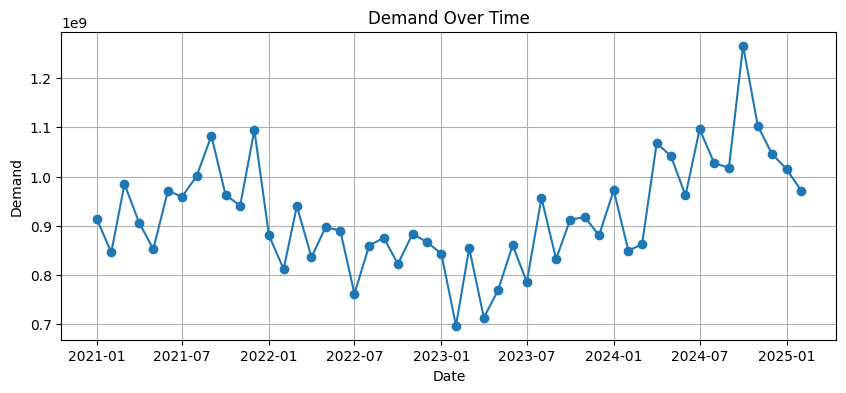

In [92]:
df = pd.read_csv("data.csv")
df["period_start"] = pd.to_datetime(df["period_start"])

# Aggregate if multiple products/regions
df_grouped = df.groupby("period_start")["value"].sum().reset_index()
df_grouped.sort_values("period_start", inplace=True)
df_grouped = df_grouped.reset_index(drop=True)

# Plot raw data
plt.figure(figsize=(10, 4))
plt.plot(df_grouped["period_start"], df_grouped["value"], marker='o')
plt.title("Demand Over Time")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.grid(True)
plt.show()

In [93]:
# LOG TRANSFORM : log1p to reduce scale and variance.
df_grouped["value_log"] = np.log1p(df_grouped["value"])  # log(1 + x)

# 4) TRAIN/TEST SPLIT (Last 6 months for test)
time_series_log = df_grouped.set_index("period_start")["value_log"]
train_log = time_series_log.iloc[:-6]
test_log = time_series_log.iloc[-6:]

# Keep also the original demand for final error metrics
time_series_orig = df_grouped.set_index("period_start")["value"]
train_orig = time_series_orig.iloc[:-6]
test_orig = time_series_orig.iloc[-6:]

print("Train range:", train_log.index.min(), "to", train_log.index.max())
print("Test range :", test_log.index.min(), "to", test_log.index.max())


Train range: 2021-01-01 00:00:00 to 2024-08-01 00:00:00
Test range : 2024-09-01 00:00:00 to 2025-02-01 00:00:00


In [94]:
# Helper function to evaluate performance
def evaluate_forecast(true_vals, pred_vals, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
    mae = mean_absolute_error(true_vals, pred_vals)
    # Avoid dividing by zero in MAPE if there's a zero
    mask = true_vals != 0
    if mask.sum() == 0:
        mape = np.nan
    else:
        mape = np.mean(np.abs((true_vals[mask] - pred_vals[mask]) / true_vals[mask])) * 100
    print(f"{model_name} Performance on Last 6 Months:")
    print(f"  RMSE = {rmse:,.2f}")
    print(f"  MAE  = {mae:,.2f}")
    print(f"  MAPE = {mape:,.2f}%\n")
    return rmse, mae, mape

# SARIMA (Univariate) Forecast

In [95]:
# Use auto_arima on train_log
auto_model = auto_arima(
    train_log,
    seasonal=True,
    m=12,
    d=None,
    D=1,
    trace=False,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print("Best ARIMA order:", auto_model.order)
print("Best Seasonal order:", auto_model.seasonal_order)

sarima_model = SARIMAX(
    train_log,
    order=auto_model.order,
    seasonal_order=auto_model.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast last 6 months
sarima_pred_test_log = sarima_model.forecast(steps=6)

sarima_pred_test = np.expm1(sarima_pred_test_log)

sarima_rmse, sarima_mae, sarima_mape = evaluate_forecast(test_orig.values, sarima_pred_test.values, "SARIMA")

# Forecast next 36 months
sarima_forecast_36_log = sarima_model.forecast(steps=36)
sarima_forecast_36 = np.expm1(sarima_forecast_36_log)
sarima_dates_36 = pd.date_range(start=train_log.index.max(), periods=36+1, freq='M')[1:]


c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force

Best ARIMA order: (2, 1, 0)
Best Seasonal order: (1, 1, 0, 12)
SARIMA Performance on Last 6 Months:
  RMSE = 88,946,160.38
  MAE  = 74,753,966.01
  MAPE = 6.97%



c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SPMCIL S S BALANI\AppData\Local\Temp\ipykernel_2176\2315833078.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sarima_dates_36 = pd.date_range(start=train_log.index.max(), periods=36+1, freq='M')[1:]


# LSTM (Univariate) Forecast

In [96]:
df_lstm = df_grouped.copy()
df_lstm.set_index("period_start", inplace=True)

# Scale
scaler = MinMaxScaler()
df_lstm["scaled"] = scaler.fit_transform(df_lstm[["value"]])

# Create sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
data_array = df_lstm["scaled"].values
X_all, y_all = create_sequences(data_array, sequence_length)

# Indices for train/test (last 6 months => last 6 points)
train_size = len(df_lstm) - 6  # index up to this for train
X_train = X_all[: train_size - sequence_length]
y_train = y_all[: train_size - sequence_length]
X_test = X_all[train_size - sequence_length:]
y_test = y_all[train_size - sequence_length:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM
model_lstm = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(128, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model_lstm.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict on test
lstm_pred_test_scaled = model_lstm.predict(X_test)
lstm_pred_test = scaler.inverse_transform(lstm_pred_test_scaled)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

lstm_rmse, lstm_mae, lstm_mape = evaluate_forecast(y_test_rescaled.flatten(), lstm_pred_test.flatten(), "LSTM")

# Forecast next 36 months
last_seq = data_array[-sequence_length:].reshape(1, sequence_length, 1)
lstm_forecast_36 = []
for _ in range(36):
    pred = model_lstm.predict(last_seq)
    lstm_forecast_36.append(pred[0,0])
    # roll
    new_seq = np.roll(last_seq, -1, axis=1)
    new_seq[0, -1, 0] = pred[0,0]
    last_seq = new_seq
lstm_forecast_36_rescaled = scaler.inverse_transform(np.array(lstm_forecast_36).reshape(-1,1)).flatten()
lstm_dates_36 = pd.date_range(start=train.index.max(), periods=36+1, freq='M')[1:]


Epoch 1/100


c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - loss: 0.1101 - val_loss: 0.4068
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1129 - val_loss: 0.3498
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0945 - val_loss: 0.2850
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0593 - val_loss: 0.2083
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0393 - val_loss: 0.1213
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0249 - val_loss: 0.0549
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0420 - val_loss: 0.0467
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0413 - val_loss: 0.0635
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0358 - val_loss: 0.0934
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0295 - val_loss: 0.1159
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0310 - val_loss: 0.1288
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0307 - val_loss: 0.1328


C:\Users\SPMCIL S S BALANI\AppData\Local\Temp\ipykernel_2176\621545728.py:60: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  lstm_dates_36 = pd.date_range(start=train.index.max(), periods=36+1, freq='M')[1:]


# XGBoost (Univariate with Lags)

In [97]:
df = pd.read_csv("data.csv")
df["period_start"] = pd.to_datetime(df["period_start"])

# Aggregate if multiple products/regions
df_grouped = df.groupby("period_start")["value"].sum().reset_index()
df_grouped.sort_values("period_start", inplace=True)
df_grouped = df_grouped.reset_index(drop=True)

# Last 6 months for test
time_series = df_grouped.set_index("period_start")["value"]
train = time_series.iloc[:-6]
test = time_series.iloc[-6:]

print("Train Range:", train.index.min(), "to", train.index.max())
print("Test Range :", test.index.min(), "to", test.index.max())

Train Range: 2021-01-01 00:00:00 to 2024-08-01 00:00:00
Test Range : 2024-09-01 00:00:00 to 2025-02-01 00:00:00


In [98]:
# lag features for the univariate time series
df_xgb = df_grouped.copy()
df_xgb.set_index("period_start", inplace=True)
max_lag = 12

for lag in range(1, max_lag+1):
    df_xgb[f'lag_{lag}'] = df_xgb['value'].shift(lag)

df_xgb.dropna(inplace=True)

# Split train/test
xgb_train = df_xgb.iloc[:-6]
xgb_test = df_xgb.iloc[-6:]

X_train_xgb = xgb_train.drop(columns=['value'])
y_train_xgb = xgb_train['value']
X_test_xgb = xgb_test.drop(columns=['value'])
y_test_xgb = xgb_test['value']

model_xgb = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05)
model_xgb.fit(X_train_xgb, y_train_xgb)

xgb_pred_test = model_xgb.predict(X_test_xgb)
xgb_rmse, xgb_mae, xgb_mape = evaluate_forecast(y_test_xgb, xgb_pred_test, "XGBoost")

# Forecast next 36 months with XGBoost
xgb_forecast_36 = []
last_data = df_xgb.iloc[-1].drop('value').values

current_values = df_xgb['value'].values
for _ in range(36):
    pred = model_xgb.predict(last_data.reshape(1, -1))[0]
    xgb_forecast_36.append(pred)

    current_values = np.append(current_values, pred)

    new_lag_features = []
    for lag in range(1, max_lag+1):
        new_lag_features.append(current_values[-lag-1])
    new_lag_features = new_lag_features[::-1]
    last_data = np.array(new_lag_features)

xgb_dates_36 = pd.date_range(start=train.index.max(), periods=36+1, freq='M')[1:]


XGBoost Performance on Last 6 Months:
  RMSE = 111,201,885.71
  MAE  = 86,429,368.00
  MAPE = 7.85%



C:\Users\SPMCIL S S BALANI\AppData\Local\Temp\ipykernel_2176\1042019371.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  xgb_dates_36 = pd.date_range(start=train.index.max(), periods=36+1, freq='M')[1:]


# Prophet (Univariate)

In [99]:
# Helper function to evaluate performance
def evaluate_forecast(true_vals, pred_vals, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
    mae = mean_absolute_error(true_vals, pred_vals)
    # Avoid dividing by zero in MAPE if there's a zero
    mask = true_vals != 0
    if mask.sum() == 0:
        mape = np.nan
    else:
        # Ensure indices are aligned before calculating MAPE
        common_index = true_vals.index.intersection(pred_vals.index)
        true_vals_aligned = true_vals.loc[common_index]
        pred_vals_aligned = pred_vals.loc[common_index]
        mask_aligned = true_vals_aligned != 0
        if mask_aligned.sum() == 0:
            mape = np.nan
        else:
            # Recalculate MAPE only on the aligned indices where true_vals are not zero
            numerator = np.abs(true_vals_aligned[mask_aligned] - pred_vals_aligned[mask_aligned])
            denominator = true_vals_aligned[mask_aligned]
            mape = np.mean(numerator / denominator) * 100

    print(f"{model_name} Performance on Last 6 Months:")
    print(f"  RMSE = {rmse:,.2f}")
    print(f"  MAE  = {mae:,.2f}")
    print(f"  MAPE = {mape:,.2f}%\n")
    return rmse, mae, mape

In [100]:
df_prophet = df_grouped.copy()
df_prophet.columns = ['ds','y']
df_prophet.sort_values('ds', inplace=True)

# Split for Prophet
prophet_train = df_prophet.iloc[:-6]
prophet_test = df_prophet.iloc[-6:]

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(prophet_train)

future_test = model_prophet.make_future_dataframe(periods=6, freq='M')
prophet_forecast_test = model_prophet.predict(future_test)

# Evaluate on last 6 months
prophet_test_pred = prophet_forecast_test[['ds','yhat']].iloc[-6:].set_index('ds')['yhat']
prophet_rmse, prophet_mae, prophet_mape = evaluate_forecast(prophet_test.set_index('ds')['y'], prophet_test_pred, "Prophet")

future_36 = model_prophet.make_future_dataframe(periods=36, freq='M')
prophet_forecast_36 = model_prophet.predict(future_36)
prophet_36 = prophet_forecast_36[['ds','yhat']].iloc[-36:]


03:03:48 - cmdstanpy - INFO - Chain [1] start processing
03:03:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet Performance on Last 6 Months:
  RMSE = 107,202,705.00
  MAE  = 87,513,219.18
  MAPE = nan%



c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
c:\Users\SPMCIL S S BALANI\Documents\B&D\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


# Comparison Plots

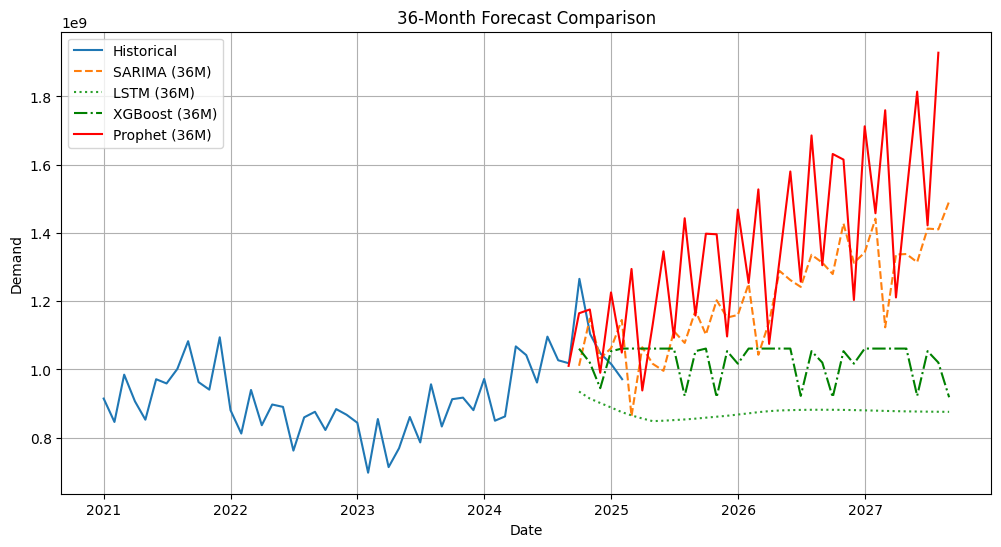

In [101]:
plt.figure(figsize=(12,6))
plt.plot(time_series.index, time_series.values, label='Historical')

# SARIMA
plt.plot(sarima_dates_36, sarima_forecast_36, label='SARIMA (36M)', linestyle='--')

# LSTM
plt.plot(lstm_dates_36, lstm_forecast_36_rescaled, label='LSTM (36M)', linestyle=':')

# XGBoost
plt.plot(xgb_dates_36, xgb_forecast_36, label='XGBoost (36M)', linestyle='-.', color='green')

# Prophet
plt.plot(prophet_36['ds'], prophet_36['yhat'], label='Prophet (36M)', linestyle='-', color='red')

plt.title("36-Month Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.show()


# Final Performance

In [102]:
print("\n=== Final Performance on Last 6 Months ===")
print(f"SARIMA  => RMSE={sarima_rmse:.2f}, MAE={sarima_mae:.2f}, MAPE={sarima_mape:.2f}%")
print(f"LSTM    => RMSE={lstm_rmse:.2f}, MAE={lstm_mae:.2f}, MAPE={lstm_mape:.2f}%")
print(f"XGBoost => RMSE={xgb_rmse:.2f}, MAE={xgb_mae:.2f}, MAPE={xgb_mape:.2f}%")
print(f"Prophet => RMSE={prophet_rmse:.2f}, MAE={prophet_mae:.2f}, MAPE={prophet_mape:.2f}%")



=== Final Performance on Last 6 Months ===
SARIMA  => RMSE=88946160.38, MAE=74753966.01, MAPE=6.97%
LSTM    => RMSE=162355513.39, MAE=125436174.67, MAPE=11.02%
XGBoost => RMSE=111201885.71, MAE=86429368.00, MAPE=7.85%
Prophet => RMSE=107202705.00, MAE=87513219.18, MAPE=nan%
